<a href="https://colab.research.google.com/github/Dhruv-2020EE30592/EECE-5644/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Headers

import numpy as np
import pandas as pd
import os

import scipy.stats
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from mpl_toolkits.mplot3d import Axes3D

# Question 1

In [2]:
# Generating samples

def generate_samples(N):
  P_L0 = 0.6
  P_L1 = 0.4

  mu_01 = [-0.9, -1.1]
  mu_02 = [0.8, 0.75]
  mu_11 = [-1.1, 0.9]
  mu_12 = [0.9, -0.75]
  sigma = [[0.75, 0], [0, 1.25]]

  samples = np.zeros((N, 2))
  L_samples = np.random.choice([0, 1], size=N, p=[P_L0, P_L1])
  for i in range(N):
    if L_samples[i] == 0:
      if np.random.rand() < 0.5:
        samples[i] = np.random.multivariate_normal(mu_01, sigma)
      else:
        samples[i] = np.random.multivariate_normal(mu_02, sigma)
    if L_samples[i] == 1:
      if np.random.rand() < 0.5:
        samples[i] = np.random.multivariate_normal(mu_11, sigma)
      else:
        samples[i] = np.random.multivariate_normal(mu_12, sigma)
    # if L_samples[i] == 0:
    #   samples[i] = 0.5*np.random.multivariate_normal(mu_01, sigma)+0.5*np.random.multivariate_normal(mu_02, sigma)
    # if L_samples[i] == 1:
    #   samples[i] = 0.5*np.random.multivariate_normal(mu_11, sigma)+0.5*np.random.multivariate_normal(mu_12, sigma)

  return samples, L_samples

In [3]:
# Visualize samples

def visualize_samples(D_samples, L_samples, ax):
  ax.scatter(D_samples[L_samples == 0][:, 0], D_samples[L_samples == 0][:, 1], color='r', label='Class 1', alpha=0.3)
  ax.scatter(D_samples[L_samples == 1][:, 0], D_samples[L_samples == 1][:, 1], color='b', label='Class 2', alpha=0.3)
  ax.legend()

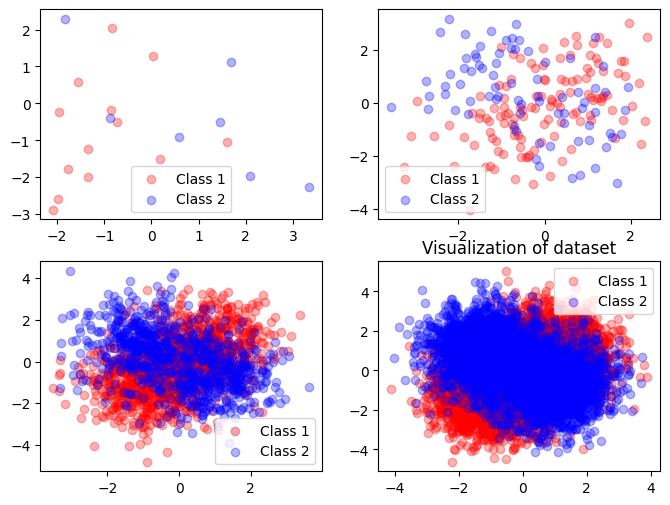

In [4]:
D_20_train, L_20_train = generate_samples(20)
D_200_train, L_200_train = generate_samples(200)
D_2000_train, L_2000_train = generate_samples(2000)
D_10000_validate, L_10000_validate = generate_samples(10000)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
visualize_samples(D_20_train, L_20_train, ax1)
visualize_samples(D_200_train, L_200_train, ax2)
visualize_samples(D_2000_train, L_2000_train, ax3)
visualize_samples(D_10000_validate, L_10000_validate, ax4)
plt.title('Visualization of dataset')
plt.show()

## Part A

In [5]:
# Classification based on max posterior probability

def MPE_classifier(x):
  P_L0 = 0.6
  P_L1 = 0.4

  mu_01 = np.array([-0.9, -1.1])
  mu_02 = np.array([0.8, 0.75])
  mu_11 = np.array([-1.1, 0.9])
  mu_12 = np.array([0.9, -0.75])
  sigma = np.array([[0.75, 0], [0, 1.25]])

  post_L0 = (0.5*scipy.stats.multivariate_normal.pdf(x, mean=mu_01, cov=sigma)+0.5*scipy.stats.multivariate_normal.pdf(x, mean=mu_02, cov=sigma))
  post_L1 = (0.5*scipy.stats.multivariate_normal.pdf(x, mean=mu_11, cov=sigma)+0.5*scipy.stats.multivariate_normal.pdf(x, mean=mu_12, cov=sigma))
  # post_L0 = scipy.stats.multivariate_normal.pdf(x, mean=0.5*(mu_01+mu_02), cov=0.5*sigma)
  # post_L1 = scipy.stats.multivariate_normal.pdf(x, mean=0.5*(mu_11+mu_12), cov=0.5*sigma)
  return np.argmax(np.stack([post_L0, post_L1], axis=1), axis=1), np.stack([post_L0, post_L1], axis=1)

In [32]:
# Confusion Matrix

def confusion_matrix(L_samples, D_samples):
  conf_matrix = np.zeros((2, 2))
  correct_assignments = 0
  total_samples = 0
  for i in range(2):
    for j in range(2):
      conf_matrix[i, j] = np.sum((L_samples == i) & (D_samples == j)) / np.sum(L_samples == i)
      total_samples += np.sum((L_samples == i) & (D_samples == j))
      if i == j:
        correct_assignments += np.sum((L_samples == i) & (D_samples == j))
  plt.figure(figsize=(6, 4))
  sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=[f'D={i}' for i in range(2)], yticklabels=[f'L={i}' for i in range(2)])
  plt.title('Confusion Matrix Heatmap')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()
  print(f'Accuracy: {correct_assignments/total_samples}')
  print(f'Minimum probability error: {1-correct_assignments/total_samples}')

In [33]:
# ROC Curve

def plot_roc_curve(actual, predicted):
  P_L0 = 0.6
  P_L1 = 0.4
  fpr, tpr, thresholds = roc_curve(actual, predicted)
  roc_auc = auc(fpr, tpr)
  P_error = fpr*P_L0 + (1-tpr)*P_L1
  min_error_index = np.argmin(P_error)
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.scatter(fpr[min_error_index], tpr[min_error_index], color='red', label=f'Min P(error) threshold (min error = {P_error[min_error_index]:.2f})', marker = 'o', s=100)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()

In [62]:
# Plotting the decision boundary

def plot_decision_bound(D_samples, L_samples):
  x_min, x_max = -3, 3
  y_min, y_max = -3, 3
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  Z, _ = MPE_classifier(grid_points)
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(6, 4))
  plt.contourf(xx, yy, Z, alpha=1, levels=1, cmap='coolwarm') # Those below contour threshold are blue and those above are red
  plt.scatter(D_samples[L_samples == 0][:, 0], D_samples[L_samples == 0][:, 1], color='b', label='Class 1', alpha=0.3)
  plt.scatter(D_samples[L_samples == 1][:, 0], D_samples[L_samples == 1][:, 1], color='r', label='Class 2', alpha=0.3)
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.title('Decision Boundary with Validation Data')
  plt.legend()
  plt.show()

In [63]:
LPred_10000_validate, LPredCont_10000_validate = MPE_classifier(D_10000_validate)
LPred_10000_validate = np.array(LPred_10000_validate).reshape(-1)
print(L_10000_validate.shape)
print(LPred_10000_validate.shape)
print(LPredCont_10000_validate[:, 1].shape)

(10000,)
(10000,)
(10000,)


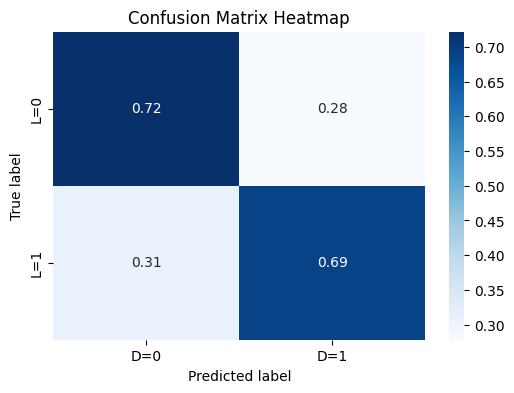

Accuracy: 0.7086
Minimum probability error: 0.2914


In [59]:
confusion_matrix(L_10000_validate, LPred_10000_validate)

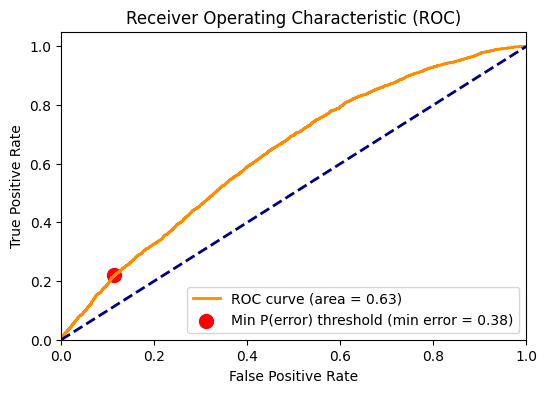

In [60]:
plot_roc_curve(L_10000_validate, LPredCont_10000_validate[:, 1])

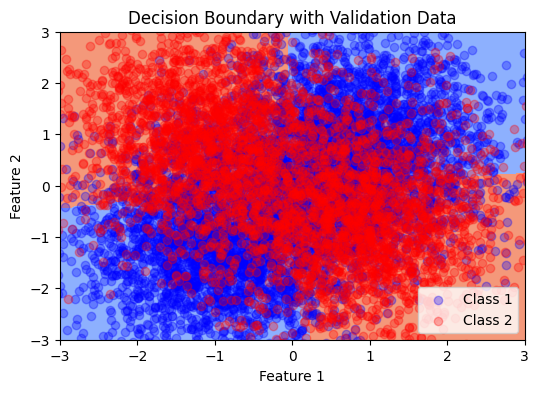

In [64]:
plot_decision_bound(D_10000_validate, L_10000_validate)

## Part B

In [13]:
# Logistic Regression
# Prevent log(0) by clipping values

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def compute_neg_log_likelihood(X, y, w, b):
  z = np.dot(X, w) + b
  predictions = sigmoid(z)
  predictions = np.clip(predictions, 1e-10, 1 - 1e-10)
  nll = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
  return nll

def gradient_descent(X, y, w, b, learning_rate, iterations):
  N = X.shape[0]
  for i in range(iterations):
      z = np.dot(X, w) + b
      predictions = sigmoid(z)

      # Compute gradients
      dw = np.dot(X.T, (predictions - y)) / N
      db = np.mean(predictions - y)

      # Update weights and bias
      w -= learning_rate * dw
      b -= learning_rate * db

      if i % 1000 == 0:
          loss = compute_neg_log_likelihood(X, y, w, b)
          # print(f"Iteration {i}: Loss = {loss:.3f}")
  return w, b

def train_logistic_regression(X, y, learning_rate=0.01, iterations=10000):
  n_features = X.shape[1]
  w = np.zeros(n_features)
  b = 0
  w, b = gradient_descent(X, y, w, b, learning_rate, iterations)
  return w, b

def predict(X, w, b):
  z = np.dot(X, w) + b
  probabilities = sigmoid(z)
  return (probabilities > 0.5).astype(int)

def evaluate_accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)

In [53]:
# Plotting the decision boundary

def plot_decision_bound_logistic(D_samples, L_samples, w, b):
  x_min, x_max = -3, 3
  y_min, y_max = -3, 3
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  Z = predict(grid_points, w, b)
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(6, 4))
  plt.contourf(xx, yy, Z, alpha=1, levels=1, cmap='coolwarm') # Those below contour threshold are blue and those above are red
  plt.scatter(D_samples[L_samples == 0][:, 0], D_samples[L_samples == 0][:, 1], color='b', label='Class 1', alpha=0.3)
  plt.scatter(D_samples[L_samples == 1][:, 0], D_samples[L_samples == 1][:, 1], color='r', label='Class 2', alpha=0.3)
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()
  plt.show()


Evaluating Model 1 on the same training dataset:
Accuracy on Dataset 1: 75.00%


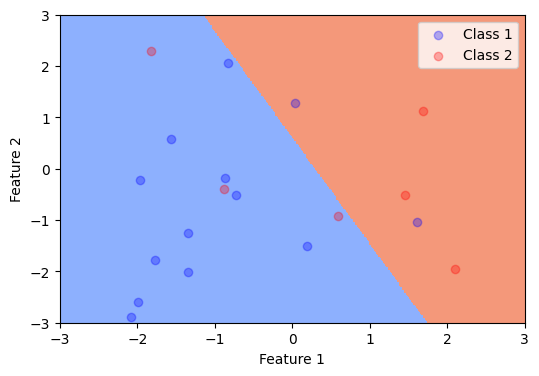


Evaluating Model 2 on the same training dataset:
Accuracy on Dataset 2: 74.00%


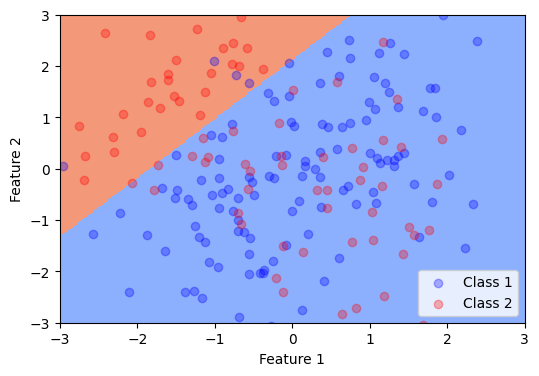


Evaluating Model 3 on the same training dataset:
Accuracy on Dataset 3: 59.30%


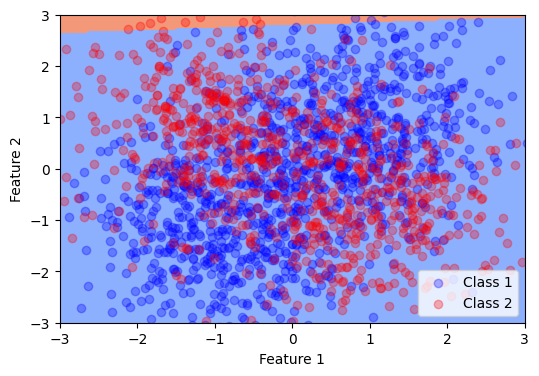


Evaluating Model 1 on validation dataset:
Accuracy on Dataset 1: 49.40%


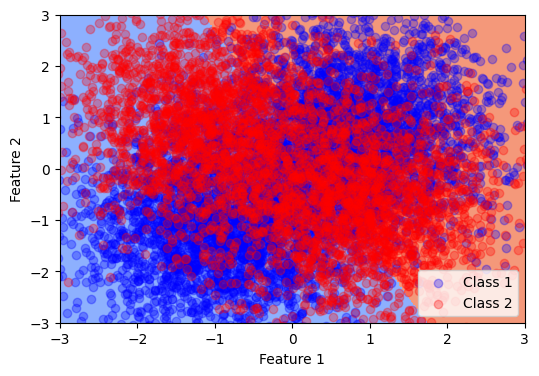


Evaluating Model 2 on validation dataset:
Accuracy on Dataset 2: 65.77%


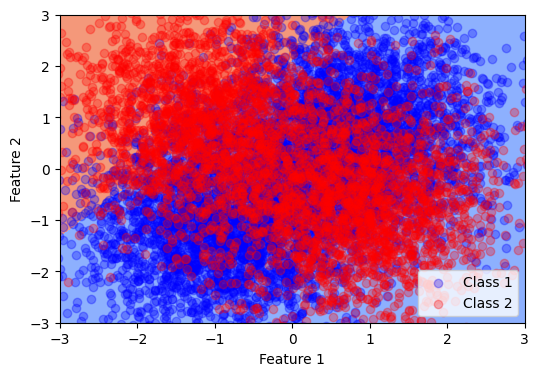


Evaluating Model 3 on validation dataset:
Accuracy on Dataset 3: 59.01%


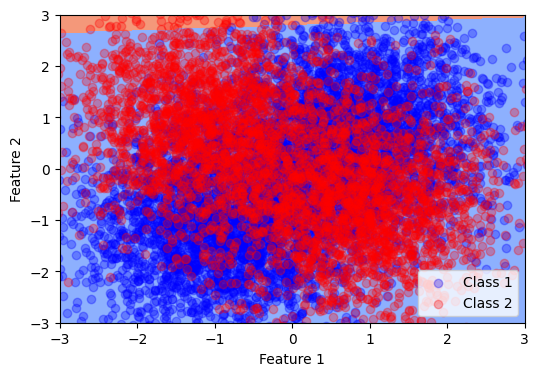

In [54]:
w1, b1 = train_logistic_regression(D_20_train, L_20_train)
w2, b2 = train_logistic_regression(D_200_train, L_200_train)
w3, b3 = train_logistic_regression(D_2000_train, L_2000_train)
for i, (X, y, w, b) in enumerate([(D_20_train, L_20_train, w1, b1), (D_200_train, L_200_train, w2, b2), (D_2000_train, L_2000_train, w3, b3)]):
  print(f"\nEvaluating Model {i+1} on the same training dataset:")
  y_pred = predict(X, w, b)
  accuracy = evaluate_accuracy(y, y_pred)
  print(f"Accuracy on Dataset {i+1}: {accuracy * 100:.2f}%")
  plot_decision_bound_logistic(X, y, w, b)
for i, (X, y, w, b) in enumerate([(D_10000_validate, L_10000_validate, w1, b1), (D_10000_validate, L_10000_validate, w2, b2), (D_10000_validate, L_10000_validate, w3, b3)]):
  print(f"\nEvaluating Model {i+1} on validation dataset:")
  y_pred = predict(X, w, b)
  accuracy = evaluate_accuracy(y, y_pred)
  print(f"Accuracy on Dataset {i+1}: {accuracy * 100:.2f}%")
  plot_decision_bound_logistic(X, y, w, b)

In [16]:
# Logistic Quadratic Function

def transform_quadratic(X):
    n_samples, n_features = X.shape
    transformed_features = [X]
    squared_features = X ** 2
    transformed_features.append(squared_features)
    for i in range(n_features):
        for j in range(i + 1, n_features):
            cross_term = (X[:, i] * X[:, j]).reshape(-1, 1)
            transformed_features.append(cross_term)
    return np.hstack(transformed_features)

def train_logistic_quadratic(X, y, learning_rate=0.01, iterations=10000):
    X_transformed = transform_quadratic(X)
    n_features = X_transformed.shape[1]
    w = np.zeros(n_features)
    b = 0
    w, b = gradient_descent(X_transformed, y, w, b, learning_rate, iterations)
    return w, b

def predict_quadratic(X, w, b):
    X_transformed = transform_quadratic(X)
    z = np.dot(X_transformed, w) + b
    probabilities = sigmoid(z)
    return (probabilities > 0.5).astype(int)

In [55]:
# Plotting the decision boundary

def plot_decision_bound_logistic_quadratic(D_samples, L_samples, w, b):
  x_min, x_max = -3, 3
  y_min, y_max = -3, 3
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  Z = predict_quadratic(grid_points, w, b)
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(6, 4))
  plt.contourf(xx, yy, Z, alpha=1, levels=1, cmap='coolwarm') # Those below contour threshold are blue and those above are red
  plt.scatter(D_samples[L_samples == 0][:, 0], D_samples[L_samples == 0][:, 1], color='b', label='Class 1', alpha=0.3)
  plt.scatter(D_samples[L_samples == 1][:, 0], D_samples[L_samples == 1][:, 1], color='r', label='Class 2', alpha=0.3)
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()
  plt.show()


Evaluating Model 1 on the same training dataset:
Accuracy on Dataset 1: 85.00%


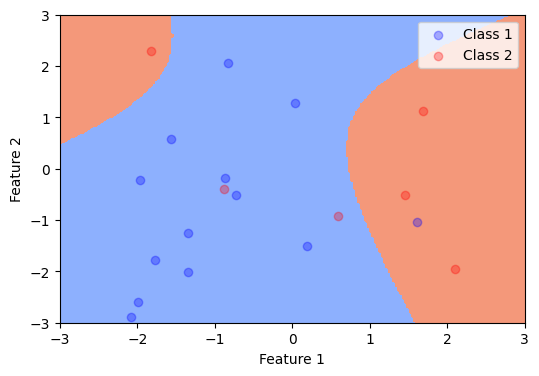


Evaluating Model 2 on the same training dataset:
Accuracy on Dataset 2: 76.50%


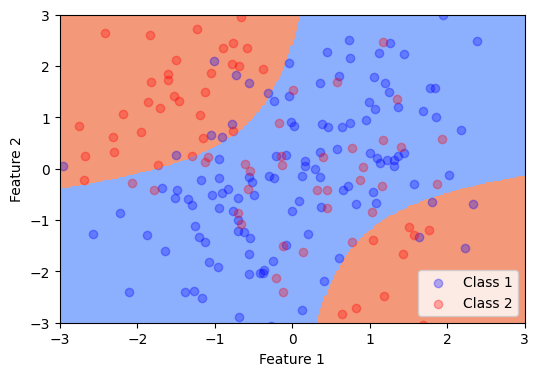


Evaluating Model 3 on the same training dataset:
Accuracy on Dataset 3: 72.90%


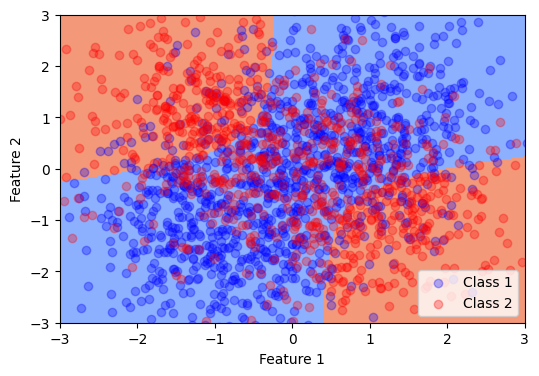


Evaluating Model 1 on validation dataset:
Accuracy on Dataset 1: 58.24%


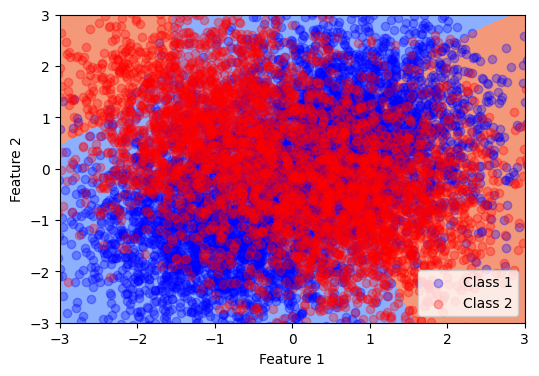


Evaluating Model 2 on validation dataset:
Accuracy on Dataset 2: 70.79%


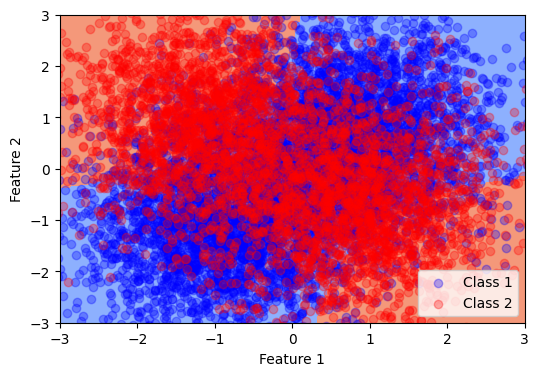


Evaluating Model 3 on validation dataset:
Accuracy on Dataset 3: 71.77%


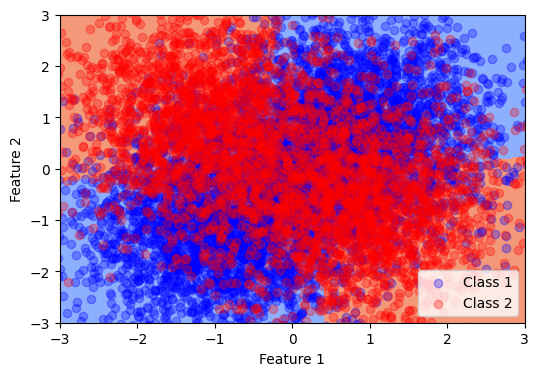

In [56]:
w1, b1 = train_logistic_quadratic(D_20_train, L_20_train)
w2, b2 = train_logistic_quadratic(D_200_train, L_200_train)
w3, b3 = train_logistic_quadratic(D_2000_train, L_2000_train)
for i, (X, y, w, b) in enumerate([(D_20_train, L_20_train, w1, b1), (D_200_train, L_200_train, w2, b2), (D_2000_train, L_2000_train, w3, b3)]):
  print(f"\nEvaluating Model {i+1} on the same training dataset:")
  y_pred = predict_quadratic(X, w, b)
  accuracy = evaluate_accuracy(y, y_pred)
  print(f"Accuracy on Dataset {i+1}: {accuracy * 100:.2f}%")
  plot_decision_bound_logistic_quadratic(X, y, w, b)
for i, (X, y, w, b) in enumerate([(D_10000_validate, L_10000_validate, w1, b1), (D_10000_validate, L_10000_validate, w2, b2), (D_10000_validate, L_10000_validate, w3, b3)]):
  print(f"\nEvaluating Model {i+1} on validation dataset:")
  y_pred = predict_quadratic(X, w, b)
  accuracy = evaluate_accuracy(y, y_pred)
  print(f"Accuracy on Dataset {i+1}: {accuracy * 100:.2f}%")
  plot_decision_bound_logistic_quadratic(X, y, w, b)

# Question 2

In [13]:
# Code given with assignment

from typing_extensions import dataclass_transform

def hw2q2():
  Ntrain = 100
  data = generateData(Ntrain)
  plot3(data[0,:],data[1,:],data[2,:], data_type='Training')
  xTrain = data[0:2,:]
  yTrain = data[2,:]
  Ntrain = 1000
  data = generateData(Ntrain)
  plot3(data[0,:],data[1,:],data[2,:], data_type='Validation')
  xValidate = data[0:2,:]
  yValidate = data[2,:]
  return xTrain.T,yTrain,xValidate.T,yValidate

def generateData(N):
  gmmParameters = {}
  gmmParameters['priors'] = [.3,.4,.3] # priors should be a row vector
  gmmParameters['meanVectors'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])
  gmmParameters['covMatrices'] = np.zeros((3, 3, 3))
  gmmParameters['covMatrices'][:,:,0] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
  gmmParameters['covMatrices'][:,:,1] = np.array([[8, 0, 0], [0, .5, 0], [0, 0, .5]])
  gmmParameters['covMatrices'][:,:,2] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
  x,labels = generateDataFromGMM(N,gmmParameters)
  return x

def generateDataFromGMM(N,gmmParameters):
  # Generates N vector samples from the specified mixture of Gaussians
  # Returns samples and their component labels
  # Data dimensionality is determined by the size of mu/Sigma parameters
  priors = gmmParameters['priors'] # priors should be a row vector
  meanVectors = gmmParameters['meanVectors']
  covMatrices = gmmParameters['covMatrices']
  n = meanVectors.shape[0] # Data dimensionality
  C = len(priors) # Number of components
  x = np.zeros((n,N))
  labels = np.zeros((1,N))
  # Decide randomly which samples will come from each component
  u = np.random.random((1,N))
  thresholds = np.zeros((1,C+1))
  thresholds[:,0:C] = np.cumsum(priors)
  thresholds[:,C] = 1
  for l in range(C):
    indl = np.where(u <= (thresholds[:,l]))
    Nl = len(indl[1])
    labels[indl] = (l+1)*1
    u[indl] = 1.1
    x[:,indl[1]] = np.transpose(np.random.multivariate_normal(meanVectors[:,l], covMatrices[:,:,l], Nl))
  return x,labels

def plot3(a,b,c,data_type,mark="o",col="b"):
  pylab.ion()
  fig = plt.figure(figsize=(6, 4))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(a, b, c,marker=mark,color=col)
  ax.set_xlabel("x1")
  ax.set_ylabel("x2")
  ax.set_zlabel("y")
  ax.set_title(f'{data_type} Dataset')
  plt.show()

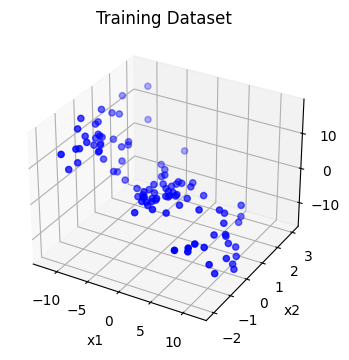

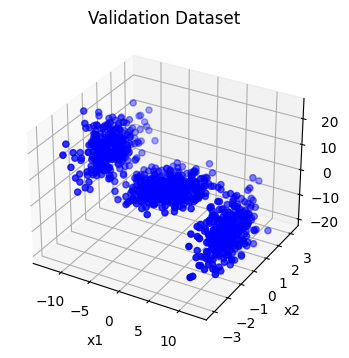

In [14]:
X_train, y_train, X_validate, y_validate = hw2q2()

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)

(100, 2)
(100,)
(1000, 2)
(1000,)


In [5]:
# ML Estimator

def cubic_polynomial(x, w):
  x1, x2 = x[:, 0], x[:, 1]
  return (w[0] + w[1] * x1 + w[2] * x2 + w[3] * x1**2 + w[4] * x2**2 + w[5] * x1**3 + w[6] * x2**3)

def negative_log_likelihood(w, X, y, sigma):
  predictions = cubic_polynomial(X, w)
  residuals = y - predictions
  # nll = 0.5 * np.sum(np.log(2 * np.pi * sigma**2) + (residuals**2) / (sigma**2))
  nll = 0.5 * np.sum(residuals**2)
  return nll

def mle(X, y, sigma):
  w_initial = np.random.randn(7)
  result = minimize(negative_log_likelihood, w_initial, args=(X, y, sigma))
  w_mle = result.x
  return w_mle

In [6]:
# MAP Estimator

def negative_log_posterior(w, X, y, sigma_v, sigma_w):
  predictions = cubic_polynomial(X, w)
  residuals = y - predictions
  # nll = 0.5 * np.sum(np.log(2 * np.pi * sigma_v**2) + (residuals**2) / (sigma_v**2))
  nll = 0.5 * np.sum((residuals**2) / (sigma_v**2))
  # n = len(w)
  # nlp = 0.5 * n * np.log(2 * np.pi * sigma_w**2) + 0.5 * np.sum((w**2) / (sigma_w**2))
  nlp = 0.5 * np.sum((w**2) / (sigma_w**2))
  return nll + nlp

def map_estimator(X, y, sigma_v, sigma_w):
  w_initial = np.random.randn(7)
  result = minimize(negative_log_posterior, w_initial, args=(X, y, sigma_v, sigma_w))
  w_map = result.x
  return w_map

In [7]:
# MSE

def mean_sq_error(X, y, w):
  predictions = cubic_polynomial(X, w)
  residuals = y - predictions
  return np.sum(residuals**2)/len(residuals)

In [8]:
sigma = 1
m = 10
n = 10
num_points = 1000

w_train_mle = mle(X_train, y_train, sigma)
mse_mle = mean_sq_error(X_validate, y_validate, w_train_mle)

gamma_space = np.logspace(-m, n, num_points)
mse_map = []
for gamma in gamma_space:
  w_train_map = map_estimator(X_train, y_train, sigma, gamma)
  mse_map.append(mean_sq_error(X_validate, y_validate, w_train_map))
mse_map = np.array(mse_map)

sigma = 1
MSE for MLE: 4.69
Minimum MSE for MAP (gamma = 0.001): 4.21


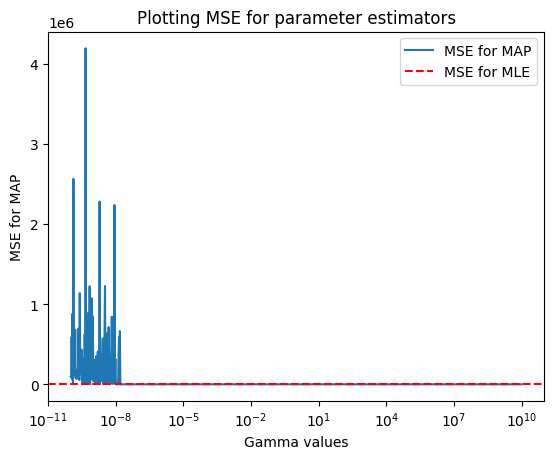

In [9]:
print(f'sigma = {sigma}')
print(f'MSE for MLE: {mse_mle:.2f}')
min_gamma = gamma_space[np.argmin(mse_map)]
min_mse_map = np.min(mse_map)
print(f'Minimum MSE for MAP (gamma = {min_gamma:.3f}): {min_mse_map:.2f}')

plt.semilogx(gamma_space, mse_map, label='MSE for MAP')
plt.axhline(y=mse_mle, color='r', linestyle='--', label='MSE for MLE')
plt.xlabel('Gamma values')
plt.ylabel('MSE for MAP')
plt.title('Plotting MSE for parameter estimators')
plt.legend()
plt.show()

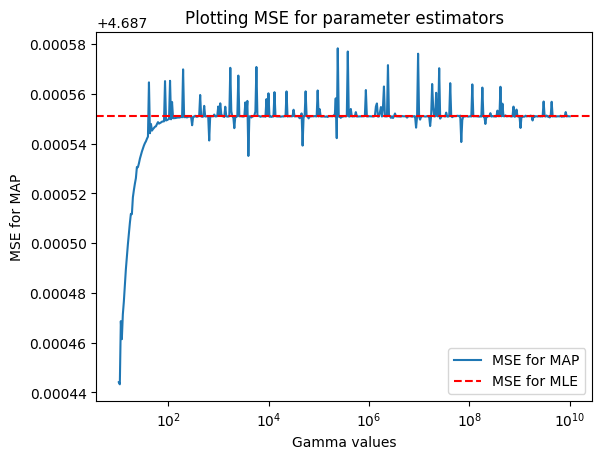

In [18]:
gamma_space_changed = []
mse_map_changed = []
for idx in range(len(gamma_space)):
  if gamma_space[idx] > 1e1:
    gamma_space_changed.append(gamma_space[idx])
    mse_map_changed.append(mse_map[idx])
gamma_space_changed = np.array(gamma_space_changed)
mse_map_changed = np.array(mse_map_changed)

plt.semilogx(gamma_space_changed, mse_map_changed, label='MSE for MAP')
plt.axhline(y=mse_mle, color='r', linestyle='--', label='MSE for MLE')
plt.xlabel('Gamma values')
plt.ylabel('MSE for MAP')
plt.title('Plotting MSE for parameter estimators')
plt.legend()
plt.show()

# Question 3

In [8]:
# MAP Estimator

def objective(position, r, sigma_r, landmarks, sigma_x, sigma_y):
  x, y = position
  prior_term = (x ** 2) / (2 * sigma_x ** 2) + (y ** 2) / (2 * sigma_y ** 2)
  likelihood_term = 0
  for i, (x_i, y_i) in enumerate(landmarks):
    distance = np.sqrt((x - x_i) ** 2 + (y - y_i) ** 2)
    likelihood_term += ((r[i] - distance) ** 2) / (2 * sigma_r[i] ** 2)
  return likelihood_term + prior_term

def map_estimator(r, sigma_r, landmarks, sigma_x, sigma_y):
  initial_position = np.array([0, 0])
  result = minimize(objective, initial_position, (r, sigma_r, landmarks, sigma_x, sigma_y), method='L-BFGS-B')
  x_map, y_map = result.x
  return x_map, y_map

In [9]:
def generate_vehicle_location():
  radius = np.sqrt(np.random.uniform(0, 1))
  angle = np.random.uniform(0, 2 * np.pi)
  x = radius * np.cos(angle)
  y = radius * np.sin(angle)
  return np.array([x, y])

def generate_landmarks(K):
  angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
  landmarks = np.array([(np.cos(angle), np.sin(angle)) for angle in angles])
  return landmarks

def generate_range_measurements(vehicle_location, landmarks, sigma_noise):
  range_measurements = []
  for i, landmark in enumerate(landmarks):
    while True:
      true_distance = np.linalg.norm(vehicle_location - landmark)
      noisy_distance = true_distance + np.random.normal(0, sigma_noise[i])
      if noisy_distance >= 0:
        range_measurements.append(noisy_distance)
        break
  return range_measurements

In [12]:
def fnx(vehicle_location, k, sigma, sigma_x, sigma_y):
  landmarks = generate_landmarks(k)
  range_measurements = generate_range_measurements(vehicle_location, landmarks, sigma)
  print(f"\nFor K = {k}:")
  print(f"True Vehicle Location: {vehicle_location}")
  print(f"Landmarks (on unit circle): {landmarks}")
  print(f"Range Measurements: {range_measurements}")
  print(f"(X_map, Y_map) = {map_estimator(range_measurements, sigma, landmarks, sigma_x, sigma_y)}")
  plot_contour(vehicle_location, range_measurements, sigma, landmarks, sigma_x, sigma_y)

def plot_contour(true_location, range_measurements, sigma, landmarks, sigma_x, sigma_y):
  x_range = np.linspace(-2, 2, 1000)
  y_range = np.linspace(-2, 2, 1000)
  X, Y = np.meshgrid(x_range, y_range)
  Z = objective((X, Y), range_measurements, sigma, landmarks, sigma_x, sigma_y)

  plt.figure(figsize=(8, 6))
  contour = plt.contour(X, Y, Z, levels=50, cmap='viridis')
  plt.colorbar(contour)
  plt.clabel(contour, inline=True, fontsize=8)

  plt.plot(true_location[0], true_location[1], 'r+', markersize=12, label='True Location')
  for i, landmark in enumerate(landmarks):
      plt.plot(landmark[0], landmark[1], 'bo', markersize=8, label=f'Landmark {i+1}')

  plt.xlim(-2, 2)
  plt.ylim(-2, 2)
  plt.title('Equilevel Contours of MAP Estimation Objective')
  plt.xlabel('Horizontal Coordinate')
  plt.ylabel('Vertical Coordinate')
  plt.axhline(0, color='black',linewidth=0.5, ls='--')
  plt.axvline(0, color='black',linewidth=0.5, ls='--')
  plt.grid()
  plt.legend()
  plt.show()


For K = 1:
True Vehicle Location: [ 0.58288649 -0.18650324]
Landmarks (on unit circle): [[1. 0.]]
Range Measurements: [0.6512169913943688]
(X_map, Y_map) = (0.14294385111590868, -6.054458016215484e-09)


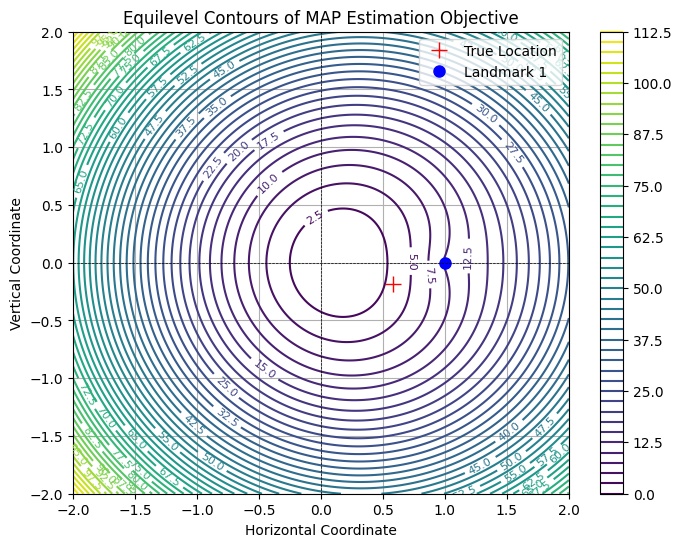


For K = 2:
True Vehicle Location: [ 0.58288649 -0.18650324]
Landmarks (on unit circle): [[ 1.0000000e+00  0.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]]
Range Measurements: [0.9138193868865686, 1.5235899567732702]
(X_map, Y_map) = (0.17725888671084045, -3.7225512044474223e-09)


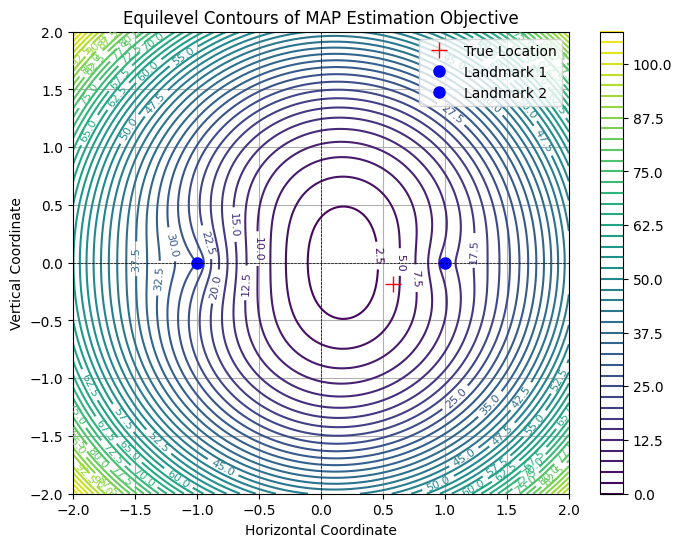


For K = 3:
True Vehicle Location: [ 0.58288649 -0.18650324]
Landmarks (on unit circle): [[ 1.         0.       ]
 [-0.5        0.8660254]
 [-0.5       -0.8660254]]
Range Measurements: [0.3866693428794069, 1.9838829464135932, 1.5086644272216598]
(X_map, Y_map) = (0.508332073667396, -0.14176588929221887)


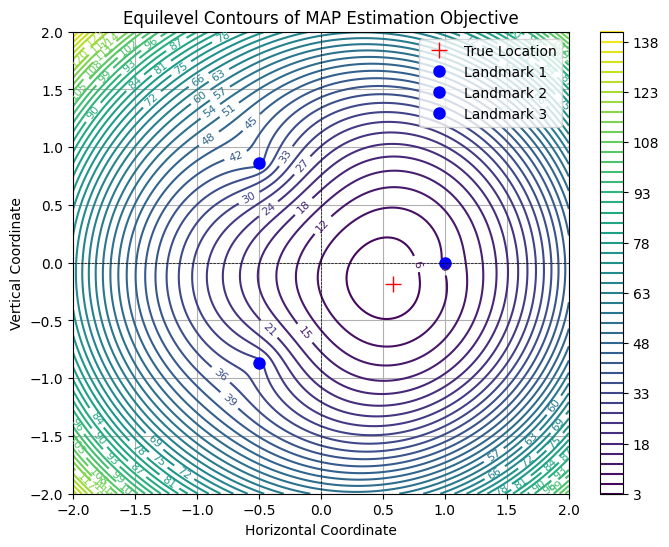


For K = 4:
True Vehicle Location: [ 0.58288649 -0.18650324]
Landmarks (on unit circle): [[ 1.0000000e+00  0.0000000e+00]
 [ 6.1232340e-17  1.0000000e+00]
 [-1.0000000e+00  1.2246468e-16]
 [-1.8369702e-16 -1.0000000e+00]]
Range Measurements: [0.3160681141836754, 1.4847160476450725, 1.4548106613465324, 0.8610475959474878]
(X_map, Y_map) = (0.3482197898875743, -0.16081472938969188)


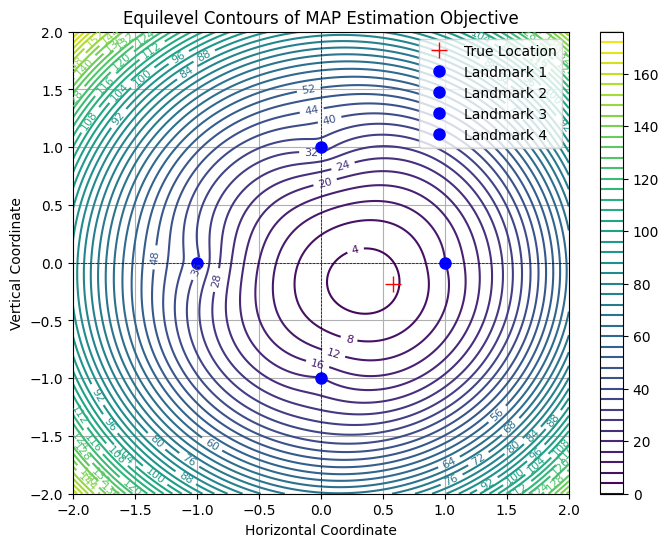

In [14]:
K_space = range(1, 5)
np.random.seed(42)

vehicle_location = generate_vehicle_location()
for K in K_space:
  sigma_noise = 0.3*np.ones(K)
  fnx(vehicle_location, K, sigma_noise, 0.25, 0.25)